# Graph Convolutional Networks for Clickbait Detection

Authors: Stephen Gelinas, Kazuma Yamamoto, Ethan Zhou\
Notebook Adapted From: Parker Erickson https://colab.research.google.com/drive/11tcL4KXXwY__TmUUTjOf6InFQMC-VsG6#scrollTo=_BNqh7fz0486 \
Pytorch Implementation of Text-GCN: https://github.com/iworldtong/text_gcn.pytorch, https://github.com/codeKgu/Text-GCN

## 1.1 Imports

In [2]:
# import dependencies
import sys
import os
import time
import spacy
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.legacy.data as ttd
import pyTigerGraph as tg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn import metrics

# import helper functions
os.chdir('../src/')
from utils import load_corpus
from torch_helpers import *

# import tigergraph config
os.chdir('../config/')
with open('tigergraph.json', 'r') as f:
    config = json.load(f)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1.2 Configuration

Here we define some variables, such as the number of epochs of training (usually only need 30 or less for a 2-layer GCN), the learning rate, and threshold for early stopping.

In [3]:
n_epochs = 50
learningRate = 0.02
early_stopping = 10

## 2.1 Creating Database Connection

This section instantiates a connection to the TigerGraph database.

In [4]:
# establish a connection to TigerGraph and load clickbait data graph
graph = tg.TigerGraphConnection(     
    host=config['host'],
    graphname=config['graphname'],
    gsqlSecret=config['gsqlSecret'])

graph.getToken(config['gsqlSecret'])
print('------------------------------------------------------------------------------')

# summary statistics and schema of the graph
n_edges = graph.getEdgeCount()['pmi']
n_verticies = graph.getVertexCount('word')
edge_stats = graph.getEdgeStats('pmi')['pmi']['value']
print('The graph has {} edges and {} verticies.'.format(n_edges, n_verticies))
print('Edges have a maximum weight of {}, minimum weight of {}, and average weight of {}.'.format(edge_stats['MAX'],
                                                                                                  edge_stats['MIN'],
                                                                                                  edge_stats['AVG']))
print('------------------------------------------------------------------------------')
print('Graph Schema: {}'.format(graph.getSchema()))

------------------------------------------------------------------------------
The graph has 402787 edges and 44543 verticies.
Edges have a maximum weight of 121, minimum weight of 0.00025, and average weight of 3.67229.
------------------------------------------------------------------------------
Graph Schema: {'GraphName': 'test1', 'VertexTypes': [{'Config': {'STATS': 'OUTDEGREE_BY_EDGETYPE'}, 'IsLocal': True, 'Attributes': [{'AttributeType': {'Name': 'STRING'}, 'AttributeName': 'clickbait'}], 'PrimaryId': {'AttributeType': {'Name': 'STRING'}, 'AttributeName': 'id'}, 'Name': 'word'}], 'EdgeTypes': [{'IsDirected': False, 'ToVertexTypeName': 'word', 'Config': {}, 'IsLocal': True, 'Attributes': [{'AttributeType': {'Name': 'FLOAT'}, 'AttributeName': 'value'}], 'FromVertexTypeName': 'word', 'Name': 'pmi'}], 'UDTs': []}


![test](images/graph.png)

## 3.1 Creating Graph Convolutional Network

Here, we create the GCN. A two-layered GCN appears to work better than deeper networks, and this is further corroborated by the fact [this](https://arxiv.org/abs/1609.02907) paper only used a two-layered one. We also label the wanted and unwanted verticies and setup the optimizer. Since the GCN is a semi-supervised algorithm, we do not label all of the nodes to their correct classes before training.

![test](images/text_gcn.png)

In [5]:
os.chdir('../')

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus('clickbait')

features = sp.identity(features.shape[0]) 
features = torch_preprocess_features(features)
support = [torch_preprocess_adj(adj)]
num_supports = 1    
    
# Define placeholders
t_features = torch.from_numpy(features)
t_y_train = torch.from_numpy(y_train)
t_y_val = torch.from_numpy(y_val)
t_y_test = torch.from_numpy(y_test)
t_train_mask = torch.from_numpy(train_mask.astype(np.float32))
tm_train_mask = torch.transpose(torch.unsqueeze(t_train_mask, 0), 1, 0).repeat(1, y_train.shape[1])

t_support = []
for i in range(len(support)):
    t_support.append(torch.Tensor(support[i]))
        
model = GCN(input_dim=features.shape[0], support=t_support, num_classes=y_train.shape[1])

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

# Define model evaluation function
def evaluate(features, labels, mask):
    t_test = time.time()
    model.eval()
    with torch.no_grad():
        logits = model(features)
        t_mask = torch.from_numpy(np.array(mask*1., dtype=np.float32))
        tm_mask = torch.transpose(torch.unsqueeze(t_mask, 0), 1, 0).repeat(1, labels.shape[1])
        loss = criterion(logits * tm_mask, torch.max(labels, 1)[1])
        pred = torch.max(logits, 1)[1]
        acc = ((pred == torch.max(labels, 1)[1]).float() * t_mask).sum().item() / t_mask.sum().item()
    return loss.numpy(), acc, pred.numpy(), labels.numpy(), (time.time() - t_test)

(23040, 300) (23040, 2) (6400, 300) (6400, 2) (31950, 300) (31950, 2)
38350


## 3.2 Training Loop

Below is the training loop that trains the GCN. Unlike many traditional deep learning architectures, GCNs don't always need that much training or as large of data sets due to their exploitation of the *structure* of the data, as opposed to only the features of the data.

In [6]:
epochs = []
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train model
for epoch in range(n_epochs):
    t = time.time()

    # Forward pass
    logits = model(t_features)
    loss = criterion(logits * tm_train_mask, torch.max(t_y_train, 1)[1])    
    acc = ((torch.max(logits, 1)[1] == torch.max(t_y_train, 1)[1]).float() * t_train_mask).sum().item() / t_train_mask.sum().item()
        
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    val_loss, val_acc, pred, labels, duration = evaluate(t_features, t_y_val, val_mask)
    val_losses.append(val_loss)
    epochs.append(epoch + 1)
    train_losses.append(loss)
    train_accs.append(acc)
    val_accs.append(val_acc)
    print("Epoch: {:.0f}, train_loss= {:.5f}, train_acc= {:.5f}, val_loss= {:.5f}, val_acc= {:.5f}, time= {:.5f}"\
                .format(epoch + 1, loss, acc, val_loss, val_acc, time.time() - t))
    
    # Early Stopping
    if epoch > early_stopping and val_losses[-1] > np.mean(val_losses[-(early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 1, train_loss= 0.70932, train_acc= 0.52313, val_loss= 0.67550, val_acc= 0.90859, time= 52.51760
Epoch: 2, train_loss= 0.53416, train_acc= 0.90599, val_loss= 0.66517, val_acc= 0.94531, time= 49.85001
Epoch: 3, train_loss= 0.43909, train_acc= 0.95035, val_loss= 0.65976, val_acc= 0.95156, time= 51.17712
Epoch: 4, train_loss= 0.38791, train_acc= 0.96042, val_loss= 0.65698, val_acc= 0.95703, time= 51.13026
Epoch: 5, train_loss= 0.36038, train_acc= 0.96398, val_loss= 0.65553, val_acc= 0.95664, time= 52.11927
Epoch: 6, train_loss= 0.34495, train_acc= 0.96654, val_loss= 0.65476, val_acc= 0.95859, time= 53.17798
Epoch: 7, train_loss= 0.33573, train_acc= 0.96814, val_loss= 0.65436, val_acc= 0.95859, time= 56.67760
Epoch: 8, train_loss= 0.32976, train_acc= 0.96992, val_loss= 0.65414, val_acc= 0.95859, time= 56.80989
Epoch: 9, train_loss= 0.32550, train_acc= 0.97127, val_loss= 0.65404, val_acc= 0.95937, time= 57.36309
Epoch: 10, train_loss= 0.32220, train_acc= 0.97244, val_loss= 0.65401, va

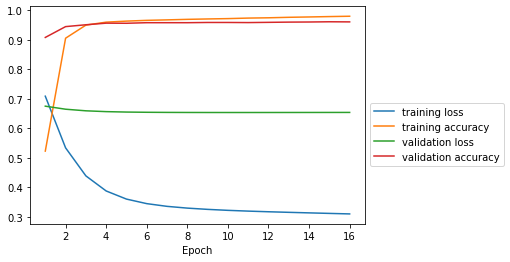

In [7]:
# Visualize training, testing, validation curves
plt.plot(epochs, train_losses, label = "training loss")
plt.plot(epochs, train_accs, label = "training accuracy")
plt.plot(epochs, val_losses, label = "validation loss")
plt.plot(epochs, val_accs, label = "validation accuracy")
plt.legend()
plt.legend(bbox_to_anchor=(1, 0.58))
plt.xlabel("Epoch")
plt.show()

## 3.4 Testing Accuracy

Here is the code that processes the GCN's results and calculates the accuracy based off the verticies that the user has reviewed, but were not labelled in the graph for the GCN to use. While this accuracy is pretty mediocre, the GCN does make predictions based off of movies sharing the same genre, and therefore with better data, there could be (and almost certainly would be) an improvement in accuracy.

In [8]:
# Testing
test_loss, test_acc, pred, labels, test_duration = evaluate(t_features, t_y_test, test_mask)
print("Test set results: \n\t loss= {:.5f}, accuracy= {:.5f}, time= {:.5f}".format(test_loss, test_acc, test_duration))

test_pred = []
test_labels = []
for i in range(len(test_mask)):
    if test_mask[i]:
        test_pred.append(pred[i])
        test_labels.append(np.argmax(labels[i]))

print("Test Precision, Recall and F1-Score...")
print(metrics.classification_report(test_labels, test_pred, digits=4))
print("Macro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, test_pred, average='macro'))
print("Micro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, test_pred, average='micro'))

Test set results: 
	 loss= 0.59612, accuracy= 0.96344, time= 18.46231
Test Precision, Recall and F1-Score...
              precision    recall  f1-score   support

           0     0.9611    0.9659    0.9635      3199
           1     0.9658    0.9609    0.9634      3201

    accuracy                         0.9634      6400
   macro avg     0.9634    0.9634    0.9634      6400
weighted avg     0.9634    0.9634    0.9634      6400

Macro average Test Precision, Recall and F1-Score...
(0.9634484156146009, 0.9634382776795193, 0.9634373250418874, None)
Micro average Test Precision, Recall and F1-Score...
(0.9634375, 0.9634375, 0.9634375, None)


## 3.5 Outputs 

**Classification Output:**

![classification](images/classification.png)


**TSNE Projections of Word Embeddings:**

![words](images/words.png)

## 4.1 Comparison to CNN

Here we will Text GCN's performance to a traditional CNN for text classification on the clickbait dataset.

In [9]:
# Load clickbait data
df = pd.read_csv('data/output/clickbait_data_cleaned.csv')
df.head()

,headline,clickbait
0,cable industry starts regret putting free show...,0
1,film director sydney dies age 73,0
2,law delay university minnesota strike,0
3,pop artist producer duo,1
4,18 facts make indian feel old,1


In [10]:
# Build train and test datasets
TEXT = ttd.Field(sequential=True,batch_first=True,lower=False,pad_first=True)
LABEL = ttd.Field(sequential=False,use_vocab=False,is_target=True)
dataset = ttd.TabularDataset(path='data/output/clickbait_data_cleaned.csv',
                             format='csv',
                             skip_header=True,
                             fields=[('data',TEXT),('label',LABEL)])

train_dataset, test_dataset = dataset.split()
TEXT.build_vocab(train_dataset,)
vocab = TEXT.vocab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset),
                                            sort_key=lambda x: len(x.data),
                                            batch_sizes=(32,256),
                                            device=device)
# Define the model
model = CNN(len(vocab),20,1)
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model using batch gradient descent
train_losses, test_losses = torch_batch_gd(model,criterion,optimizer,train_iter,test_iter, 20)

Epoch 1/20, Train Loss: 0.488385,             Test Loss: 0.367134
Epoch 2/20, Train Loss: 0.272153,             Test Loss: 0.276852
Epoch 3/20, Train Loss: 0.184349,             Test Loss: 0.243725
Epoch 4/20, Train Loss: 0.137983,             Test Loss: 0.237033
Epoch 5/20, Train Loss: 0.104893,             Test Loss: 0.225442
Epoch 6/20, Train Loss: 0.082078,             Test Loss: 0.215255
Epoch 7/20, Train Loss: 0.066412,             Test Loss: 0.274536
Epoch 8/20, Train Loss: 0.052067,             Test Loss: 0.274750
Epoch 9/20, Train Loss: 0.041856,             Test Loss: 0.241467
Epoch 10/20, Train Loss: 0.032492,             Test Loss: 0.275807
Epoch 11/20, Train Loss: 0.027101,             Test Loss: 0.270331
Epoch 12/20, Train Loss: 0.023725,             Test Loss: 0.348369
Epoch 13/20, Train Loss: 0.019788,             Test Loss: 0.344071
Epoch 14/20, Train Loss: 0.017883,             Test Loss: 0.335663
Epoch 15/20, Train Loss: 0.013382,             Test Loss: 0.329245
Epoc

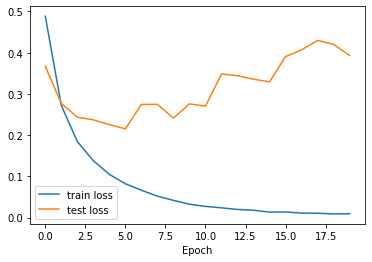

In [11]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [12]:
# Final Model's Training and Testing Accuracy
n_correct = 0
n_total = 0
for inputs, targets in train_iter:
    targets = targets.view(-1,1).float()
    outputs = model(inputs)
    predictions = (outputs > 0)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total
n_correct = 0
n_total = 0
for inputs, targets in test_iter:
    targets = targets.view(-1,1).float()
    outputs = model(inputs)
    predictions = (outputs > 0)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
test_acc = n_correct / n_total
print(f"Train acc: {train_acc:4f}, Test acc: {test_acc:4f}")

Train acc: 0.997321, Test acc: 0.932396


Compared to Text GCN, our CNN is overfit to its training data and has a resultant worse testing accuracy. CNN's performance for text classification tasks can be improved with more hidden layers, however, we find Text GCN performs better than CNN for text classification, when this task is framed as a node classification problem.